In [1]:
#using Revise
using DrWatson
@quickactivate "ABoxWorld"
include(srcdir("ABoxWorld.jl"));

┌ Info: ABoxWorld project environment is loaded and active
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\src\ABoxWorld.jl:10


In [2]:
using LinearAlgebra
using TensorOperations
using CairoMakie
CairoMakie.activate!()
#using GLMakie
#GLMakie.activate!()

In [3]:

convert_matrixbox_to_nsjoint = wirings.convert_matrixbox_to_nsjoint
convert_nsjoint_to_matrixbox = wirings.convert_nsjoint_to_matrixbox


# Boxes as 2x2x2x2 tensors

MaxMixedBox = nsboxes.reconstructFullJoint(UniformRandomBox((2, 2, 2, 2)))
PR(μ, ν, σ) = nsboxes.reconstructFullJoint(PRBoxesCHSH(;μ=μ, ν=ν, σ=σ))
CanonicalPR = PR(0, 0, 0)
PL(α, γ, β, λ) = nsboxes.reconstructFullJoint(LocalDeterministicBoxesCHSH(;α=α, γ=γ, β=β, λ=λ))
SR = (PL(0,0,0,0) .+ PL(0,1,0,1)) ./ 2
#SR = matrix_to_tensor(non_local_boxes.utils.SR)
#PRprime = matrix_to_tensor(non_local_boxes.utils.PRprime)
#P0 = matrix_to_tensor(non_local_boxes.utils.P_0)
#P1 = matrix_to_tensor(non_local_boxes.utils.P_1)


CHSH_score = games.canonical_CHSH_score
#CHSHprime_score = games.CHSH_score_generator(-1,1,1,1; batched=false)
CHSHprime_score = games.CHSH_score_generator(1,-1,1,1; batched=false)


BoxProduct = wirings.tensorized_boxproduct
reduc_BoxProduct = wirings.reduc_tensorized_boxproduct
BoxProduct_matrices(w::Matrix{<:Real}, matrixbox1::Matrix{Float64}, matrixbox2::Matrix{Float64}) = convert_nsjoint_to_matrixbox(reduc_BoxProduct(w, matrixbox1, matrixbox2))


IC_Bound = Original_IC_Bound()
IC_Bound_LHS(P::Array{Float64, 4}) = conditions.evaluate(IC_Bound, P)
IC_Bound_LHS(W::Matrix{<:Real}, P_mat::Matrix{Float64}, Q_mat::Matrix{Float64}) = games.Original_IC_Bound_score(W, P_mat, Q_mat)
IC_Bound_LHS(W::Vector{<:Real}, P_mat::Matrix{Float64}, Q_mat::Matrix{Float64}) = games.Original_IC_Bound_score(W, P_mat, Q_mat)

IC_MutInfo = games.MutInfo_IC_vanDam_score



MutInfo_IC_vanDam_score (generic function with 5 methods)

In [4]:
#npa_test_py(PL(0,0,0,0), 3)

In [5]:
println(sdp_conditions.is_in_pyNPA(npa_point1; level=3))
#p=0.2
#println(npa_test_py(p*((PL(0,0,0,0) .+ npa_point1) ./ 2) .+ (1-p)*MaxMixedBox; level=3))


UndefVarError: UndefVarError: `npa_point1` not defined

In [6]:

function Compute_Coeff(P1::Array{Float64,4}, P2::Array{Float64,4}, P3::Array{Float64,4}, alt_G_score_val::Real, CHSH_score_val::Real, alt_Game_score::Function) # P1, P2, P3 are 2x2x2x2 tensors
    A = [alt_Game_score(P1) alt_Game_score(P2) alt_Game_score(P3);
           CHSH_score(P1)     CHSH_score(P2)     CHSH_score(P3);
                1                    1                1           ]
    b = [alt_G_score_val, CHSH_score_val, 1]
    return A \ b # Equiv. to np.linalg.solve(A, b)
end


function is_in_NPA_TLM(alt_G_score_val::Real,CHSH_score_val::Real, Box1::Array{Float64,4}, Box2::Array{Float64,4}, Box3::Array{Float64,4}, alt_Game_score::Function)
    α, β, γ = Compute_Coeff(Box1, Box2, Box3, alt_G_score_val, CHSH_score_val, alt_Game_score)
    Box = α*Box1 + β*Box2 + γ*Box3
    # Box is a 2x2x2x2 tensor
    #return conditions.check(NPA_TLM_Criterion(), Box)

    E_xy = ProbBellCorrelator(Box)
    coeff00 = asin(E_xy[1,1])
    coeff01 = asin(E_xy[1,2])
    coeff10 = asin(E_xy[2,1])
    coeff11 = asin(E_xy[2,2])
    return coeff00 + coeff01 + coeff10 - coeff11 <= pi
end



function is_in_NPA(alt_G_score_val::Real,CHSH_score_val::Real, Box1::Array{Float64,4}, Box2::Array{Float64,4}, Box3::Array{Float64,4}, alt_Game_score::Function, level::Int)
    α, β, γ = Compute_Coeff(Box1, Box2, Box3, alt_G_score_val, CHSH_score_val, alt_Game_score)
    Box = α*Box1 + β*Box2 + γ*Box3
    # Box is a 2x2x2x2 tensor
    return sdp_conditions.is_in_NPA(Box; level=level, verbose=false)    
end



function is_asymp_in_pyNPA(alt_G_score_val::Real,CHSH_score_val::Real, Box1::Array{Float64,4}, Box2::Array{Float64,4}, Box3::Array{Float64,4}, alt_Game_score::Function, level::Int)
    α, β, γ = Compute_Coeff(Box1, Box2, Box3, alt_G_score_val, CHSH_score_val, alt_Game_score)
    Box = α*Box1 + β*Box2 + γ*Box3
    # Box is a 2x2x2x2 tensor
    return sdp_conditions.is_asymp_in_pyNPA(Box; level=level, verbose=false)
end


function is_in_pyNPA(alt_G_score_val::Real,CHSH_score_val::Real, Box1::Array{Float64,4}, Box2::Array{Float64,4}, Box3::Array{Float64,4}, alt_Game_score::Function, level::Int)
    α, β, γ = Compute_Coeff(Box1, Box2, Box3, alt_G_score_val, CHSH_score_val, alt_Game_score)
    Box = α*Box1 + β*Box2 + γ*Box3
    # Box is a 2x2x2x2 tensor
    return sdp_conditions.is_in_pyNPA(Box; level=level, verbose=false)
end

function min_distance_to_pyNPA(alt_G_score_val::Real,CHSH_score_val::Real, Box1::Array{Float64,4}, Box2::Array{Float64,4}, Box3::Array{Float64,4}, alt_Game_score::Function, level::Int)
    α, β, γ = Compute_Coeff(Box1, Box2, Box3, alt_G_score_val, CHSH_score_val, alt_Game_score)
    p_obs = α*Box1 + β*Box2 + γ*Box3
    # Box is a 2x2x2x2 tensor
    return sdp_conditions.min_distance_to_pyNPA(p_obs; level=level, verbose=false)
end

    
function nearest_pyNPA_point(alt_G_score_val::Real,CHSH_score_val::Real, Box1::Array{Float64,4}, Box2::Array{Float64,4}, Box3::Array{Float64,4}, alt_Game_score::Function, level::Int)
    α, β, γ = Compute_Coeff(Box1, Box2, Box3, alt_G_score_val, CHSH_score_val, alt_Game_score)
    p_obs = α*Box1 + β*Box2 + γ*Box3
    # Box is a 2x2x2x2 tensor
    return sdp_conditions.nearest_pyNPA_point(p_obs; level=level, verbose=false)
end


nearest_pyNPA_point (generic function with 1 method)

In [7]:
#Experimental implementations of distance-objective NPA'S
# NOTE: Didn't work out, just for reference
"""
using JuMP, MosekTools
include(srcdir("QuantumNPA/QuantumNPA.jl"))
#using ..QuantumNPA

function approx_NPA_Q_test_jl(FullNSJoint::Array{Float64,4}; level::Int, verbose=false)
    Box = nsboxes.NSBox((2,2,2,2), FullNSJoint)
    PA = projector(1, 1:2, 1:2, full=true)
    PB = projector(2, 1:2, 1:2, full=true)
    
    j_mo = JuMP.Model(Mosek.Optimizer)
    @JuMP.variable(j_mo, λ)

    eq_constraints = [PA[1,1] - (1-λ)*Box.marginals_vec_A[1]*Id - (λ/2)*Id,
                    PA[1,2] - (1-λ)*Box.marginals_vec_A[2]*Id - (λ/2)*Id,
                    PB[1,1] - (1-λ)*Box.marginals_vec_B[1]*Id - (λ/2)*Id,
                    PB[1,2] - (1-λ)*Box.marginals_vec_B[2]*Id - (λ/2)*Id,
                    (PA[1,i]*PB[1,j] - (1-λ)*Box.joints_mat[i,j]*Id - (λ/4)*Id for (i,j) in Iterators.product(1:2, 1:2))...,
                    ]


    #P = (1-λ)*p_obs + λ*MaxMiedBox
    #eq_constraints = [PA[a,x]*PB[b,y] - *FullNSJoint[a, b, x, y]*QuantumNPA.Id - (λ/4)*QuantumNPA.Id  #* MaxMixedBox[a+1, b+1, x+1, y+1])
    #               for (x, y, a, b) in Iterators.product(1:2, 1:2, 1:2, 1:2)]
    
    j_mo, j_vars = npa2jump(λ*QuantumNPA.Id, level; goal=:minimize, eq=eq_constraints, solver=Mosek.Optimizer, return_vars=true, model=j_mo)

    if !verbose
        set_attribute(j_mo, "QUIET", true)
        set_attribute(j_mo, "INTPNT_CO_TOL_DFEAS", 1e-7)
    end

    optimize!(j_mo)
    @show JuMP.value(λ)
    if is_solved_and_feasible(j_mo)
        return JuMP.value(λ) >= 0.0 # 
    else
        return false
    end
end


function distance_NPA_Q_jl(FullNSJoint::Array{Float64,4}; level::Int, verbose=false)
    
    PA = projector(1, 1:2, 1:2)
    PB = projector(2, 1:2, 1:2)

    j_mo = JuMP.Model(Mosek.Optimizer)
    Δ = @variable(j_mo, Δ[1:2, 1:2, 1:2, 1:2])

    eq_constraints = []
    for (i,j, k, l) in Iterators.product(1:2, 1:2, 1:2, 1:2)
        push!(eq_constraints, PA[i,k]*PB[j,l] - FullNSJoint[i,j,k,l]*Id + Δ[i,k,j,l]*Id)
        push!(eq_constraints, -PA[i,k]*PB[j,l] + FullNSJoint[i,j,k,l]*Id + Δ[i,k,j,l]*Id)
    end

    j_mo, j_vars = npa2jump(sum(Δ)*QuantumNPA.Id, level; eq=eq_constraints, solver=Mosek.Optimizer, return_vars=true)

    if !verbose
        set_attribute(j_mo, "QUIET", true)
        set_attribute(j_mo, "INTPNT_CO_TOL_DFEAS", 1e-7)
    end

    optimize!(j_mo)
    if is_solved_and_feasible(j_mo)
        return true
        #return JuMP.value(λ) < 0.0 # 
    else
        return false
    end
end
"""

"using JuMP, MosekTools\ninclude(srcdir(\"QuantumNPA/QuantumNPA.jl\"))\n#using ..QuantumNPA\n\nfunction approx_NPA_Q_test_jl(FullNSJoint::Array{Float64,4}; level::Int, verbose=false)\n    Box = nsboxes.NSBox((2,2,2,2), FullNSJoint)\n    PA = projector(1, 1:2, 1:2, full=true)\n   " ⋯ 1917 bytes ⋯ "ose\n        set_attribute(j_mo, \"QUIET\", true)\n        set_attribute(j_mo, \"INTPNT_CO_TOL_DFEAS\", 1e-7)\n    end\n\n    optimize!(j_mo)\n    if is_solved_and_feasible(j_mo)\n        return true\n        #return JuMP.value(λ) < 0.0 # \n    else\n        return false\n    end\nend\n"

In [11]:
lvl = 2
#b1 = @btime primal_NPA_Q_test($PL(0,0,0,0); level=lvl)
#b2 = @btime fulljoint_NPA_Q_test($PL(0,0,0,0); level=lvl)
#b3 = approx_NPA_Q_test_jl(PL(0,0,0,0); level=lvl)
#b3 = approx_dual_NPA_Q_test(CanonicalPR; level=lvl)
#@show b1, b2

# DIrect distance computation:
function direct_total_var_distance(p_obs::Array{Float64,4}, p_npa::Array{Float64,4})
    return sum(abs.(p_npa - p_obs))
end


@info "According to the pyNPA optimization, the distance of PR to the singlet in Q is: "
@info sdp_conditions.min_distance_to_pyNPA(CanonicalPR; level=lvl, solver="mosek")
@info "The direct distance computation gives:"
@info direct_total_var_distance(CanonicalPR, nsboxes.reconstructFullJoint( MaxEntangledBoxCHSH() ))

┌ Info: According to the pyNPA optimization, the distance of PR to the singlet in Q is: 
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\test\sdp_tests.ipynb:14
┌ Info: 1.1715726697565698
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\test\sdp_tests.ipynb:15


In [9]:
#Check npa-3 distance computation runtime
### npa_point1 = nearest_npa_point(PR(0,0,0); level=2)



In [10]:


###npa_point1 = nearest_npa_point(PR(0,0,0); level=2)
#npa_point2 = nearest_npa_point((PL(0,0,0,0) .+ npa_point1) ./ 2; level=2, verbose=true)

###@show CHSHprime_score(npa_point2), CHSH_score(npa_point2)




In [11]:

#maximum(abs.(nearest_npa_point(npa_point1; level=3)-npa_point1))
#maximum(abs.(npa_point2 - PL(0,0,0,0)))
###maximum(abs.([0.426790563306338 0.07320850863106249; 0.07321045239850521 0.4267904756640942;;; 0.4267669501621665 0.07323541732443017; 0.07323406554267675 0.4267635669707266;;;; 0.42676069637574837 0.07323837556165214; 0.07323697529049183 0.4267639527721076;;; 0.07321134570271956 0.42679102178387707; 0.4267863259635206 0.0732113065498827] - npa_point1))

#maximum(abs.(nearest_npa_point(p*PL(0,0,0,0) .+ (1-p)*npa_point1; level=3) - (PL(0,0,0,0))))


#tbox = MaxMixedBox #PL(0,0,0,0)
#maximum(abs.(nearest_npa_point(tbox; level=3) - tbox))
#CHSHprime_score(nearest_npa_point(tbox; level=3))

#### Nearest-point test

In [12]:

function draw_nearest_boxes(;Box1::Pair{String, Array{Float64,4}}, Box2::Pair{String, Array{Float64,4}}, Box3::Pair{String, Array{Float64,4}}, member_npa_level::Int, dist_npa_level::Int, alt_Game_score::Function, precision::Float64=0.001, precisionQ::Float64=1e-4, markersize::Real=4, big::Bool=true, verbose::Bool=false)
    # P, P1, P2, P3 are 2x2x2x2 matrices
    # P1 is the most non-local box
    # P2 is the most local box
    # P3 is the box that is local but scores less in CHSH than P1 (often on boundary of Q set)

    P1, P2, P3 = Box1.second, Box2.second, Box3.second

    # Draw the initial background triangle:
    x1, y1 = alt_Game_score(P1), CHSH_score(P1) #Stays CHSH because it's the coordinate system of the plot, also in IC
    x2, y2 = alt_Game_score(P2), CHSH_score(P2)
    x3, y3 = alt_Game_score(P3), CHSH_score(P3)

    # Check if our coordinate system is good, i.e. if projected points aren't aligned (= allow 2D viz.):
    ( (x1 - x3)*(y2-y3)==(x2-x3)*(y1-y3) ) && error("We can't make a 2D plot from a 0D or 1D space of points.")
    
    
    # Initialize figure and colors:
    orig_point_color = :deepskyblue3
    nearest_quantum_point_color = :orangered
    NS_color = :black
    Quantum_color = "#e82051"

    fig = Figure(; size=(800,600))
    title_visible = false
    ax = Axis(fig[1, 1]; xlabel = "CHSH'", ylabel = "CHSH", xlabelsize=(big ? 12 : 10), ylabelsize=(big ? 12 : 10),
            #titlevisible=title_visible, titlesize=(big ? 15 : 12.5), title =L"IC Violating Boxes ($K_{{reset}}$=%$(K_reset), χ=%$(χ), m=$10^%$(Int(log10(m)))$, M=%$(LS_iterations), N=%$(max_power)).",
            )
    xlims!(ax, min(x1, x2, x3), max(x1, x2, x3))
    #ylims!(ax, min(y1, y2, y3), max(y1, y2, y3))
    ylims!(ax, 2, 4)

    
     # Draw Q-set nearest points
     dist_resolution = 0.01
     ns_alt_G_scores = min(x2,x3):dist_resolution:max(x2, x3)
     ns_CHSH_scores = 2:dist_resolution:4
     
     n_points, n_trails = 1, 2
     drawn_points = 0
     for t in 1:n_trails
        c_alt_G_score_val = rand(ns_alt_G_scores)
        c_CHSH_score_val = rand(minimum(ns_CHSH_scores):dist_resolution:(maximum(ns_CHSH_scores) - c_alt_G_score_val + precisionQ)) # rand(ns_CHSH_scores)
        c_alt_G_score_val, c_CHSH_score_val = (1.0, 2.55)
        if !is_in_NPA(c_alt_G_score_val, c_CHSH_score_val, P1, P2, P3, alt_Game_score, member_npa_level)
            scatter!(ax, [c_alt_G_score_val], [c_CHSH_score_val], markersize=markersize, color=orig_point_color)
            
            #α, β, γ = Compute_Coeff(P1, P2, P3, c_alt_G_score_val, c_CHSH_score_val, alt_Game_score)
            #NLBox = α*P1 + β*P2 + γ*P3
            #nearestQBox = nearest_pyNPA_point(NLBox ;level=dist_npa_level, verbose=verbose)
            nearestQBox = nearest_pyNPA_point(c_alt_G_score_val, c_CHSH_score_val, P1, P2, P3, alt_Game_score, dist_npa_level)
            
            nearestQBoxPoint = (alt_Game_score(nearestQBox), CHSH_score(nearestQBox))
            @show nearestQBoxPoint
            scatter!(ax, [nearestQBoxPoint[1]], [nearestQBoxPoint[2]], markersize=markersize, color=nearest_quantum_point_color)
            
            drawn_points += 1
            if drawn_points >= n_points
                break
            end
         end
     end
    


    text!(ax, Box1.first, position=(x1+0.001, y1), space = :data, align = (:center, :baseline),font = :bold)
    text!(ax, Box2.first, position=(x2, y2-0.007), space = :data, align = (:center, :center),font = :bold)
    text!(ax, Box3.first, position=(x3, y3-0.007), space = :data, align = (:center, :center),font = :bold)

    #Draw the Boundary of the NS set:
    ns_boundary_line = lines!(ax, [x1, x2, x3, x1], [y1, y2, y3, y1]; color=NS_color, linewidth=3)
    #triangle = plt.Polygon(np.array([[x1, y1], [x2,y2], [x3, y3]]), color=NS_color)

    
    # Draw the Quantum area:
    c_alt_G_score_val=min(x2,x3) #Initialize at x-axis origin
    c_CHSH_score_val=4 #Safely initialize at the maximum local value of CHSH
    Quantum_alt_G_scores = Float64[]
    Quantum_CHSH_scores = Float64[]
    while c_alt_G_score_val <= max(x2, x3)
        #Check NPA-Q membership with and without security check
        if is_in_NPA(c_alt_G_score_val, c_CHSH_score_val, P1, P2, P3, alt_Game_score, member_npa_level)
        #if is_in_NPA(c_alt_G_score_val, c_CHSH_score_val, P1, P2, P3, alt_Game_score, member_npa_level) && is_asymp_in_pyNPA(c_alt_G_score_val, c_CHSH_score_val, P1, P2, P3, alt_Game_score, member_npa_level) 
            
            push!(Quantum_alt_G_scores, c_alt_G_score_val)
            push!(Quantum_CHSH_scores, c_CHSH_score_val)
            ### Area plot line-by-line: lines!(ax, [c_alt_G_score_val, c_alt_G_score_val], [c_CHSH_score_val, y2], color=Quantum_color) # Draw a vertical line of the Q set
            c_alt_G_score_val+=precisionQ # Go to the next point along x-axis / vertical line 
            #Note that we don't need to re-initialize c_CHSH_score_val, as the convex boundary can only curve downwards anyway
        else #Else we go down along y-axis towards the Q set. 
            if c_CHSH_score_val - precisionQ > y2  #Still on the canvas of our viz.
                c_CHSH_score_val -= precisionQ
            else
                c_CHSH_score_val=y2 #Take the canvas lower-boundary as the quantum boundary (even if it's not in the Q set) 
                c_alt_G_score_val+=precisionQ # Go to the next point along x-axis / vertical line 
            end
        end
    end
    quantum_boundary_line = lines!(ax, Quantum_alt_G_scores, Quantum_CHSH_scores; color=Quantum_color, linewidth=3)


   
    #Misc. plot settings:
    
    legend_visible = true
    legend_visible ? (axislegend(ax, [ns_boundary_line, quantum_boundary_line, [MarkerElement(color = orig_point_color, marker=:circle, markersize = markersize, points = Point2f[(0.5, 0.2)]), MarkerElement(color = nearest_quantum_point_color, marker=:circle, markersize = markersize,points = Point2f[(0.5, 0.6)])]],
                                ["NS boundary","Quantum boundary", "NL & Q point-pairs"];
                                position = :rt, labelsize = (big ? 10.5 : 9.5) )) : nothing
                
    
    fig # equiv. to plt.show()
    #return precision
end

draw_nearest_boxes (generic function with 1 method)

In [13]:
"""
draw_nearest_boxes(;
    Box1= "PR"=>CanonicalPR,
    Box2= "I"=>MaxMixedBox,
    Box3= "PL(0,0,0,0)"=> PL(0,0,0,0),
    member_npa_level=3,
    dist_npa_level=2,
    alt_Game_score=CHSHprime_score,
    precision=1.4e-2,   # 1.4e-2
    precisionQ=4e-3,    # 1e-4
    markersize=10,        #2
    verbose=true,
    )
"""

"draw_nearest_boxes(;\n    Box1= \"PR\"=>CanonicalPR,\n    Box2= \"I\"=>MaxMixedBox,\n    Box3= \"PL(0,0,0,0)\"=> PL(0,0,0,0),\n    member_npa_level=3,\n    dist_npa_level=2,\n    alt_Game_score=CHSHprime_score,\n    precision=1.4e-2,   # 1.4e-2\n    precisionQ=4e-3,    # 1e-4\n    markersize=10,        #2\n    verbose=true,\n    )\n"

In [18]:

function draw_nearest_boxes_in_prob_space(;BaseBox::Array{Float64, 4}, Dim1::NTuple{4, Int}, Dim2::NTuple{4, Int},Dim3::NTuple{4, Int}, member_npa_level::Int, dist_npa_level::Int, precision::Float64=0.001, precisionQ::Float64=1e-4, markersize::Real=4, big::Bool=true, verbose::Bool=false)

    #Fix Julia 1-indxeing:
    Dim1, Dim2, Dim3 = Tuple(i+1 for i in Dim1), Tuple(i+1 for i in Dim2), Tuple(i+1 for i in Dim3)

    xy_invar = BaseBox[Dim1...] + BaseBox[Dim2...] + BaseBox[Dim3...] #Note: Dim2 value follows thus from Dim1 and Dim3 values
    x_min, x_max = max(0.0, xy_invar - 1.0), min(1.0, xy_invar)
    y_min, y_max = max(0.0, xy_invar - 1.0), min(1.0, xy_invar)

    
    # Initialize figure and colors:
    orig_point_color = :deepskyblue3
    nearest_quantum_point_color = :orangered
    NS_color = :black
    Quantum_color = "#e82051"

    fig = Figure(; size=(600,600))
    title_visible = false
    ax = Axis(fig[1, 1]; xlabel = "P$(Dim1)", ylabel =  "P$(Dim3)", xlabelsize=(big ? 12 : 10), ylabelsize=(big ? 12 : 10),
            #titlevisible=title_visible, titlesize=(big ? 15 : 12.5), title =L"IC Violating Boxes ($K_{{reset}}$=%$(K_reset), χ=%$(χ), m=$10^%$(Int(log10(m)))$, M=%$(LS_iterations), N=%$(max_power)).",
            )
    xlims!(ax, x_min, x_max)
    ylims!(ax, y_min, y_max)

    #x_vals = x_min:precisionQ:x_max
    #y_vals = y_min:precisionQ:y_max

    c_x, c_y = x_min, y_min
    NS_x_vals = Float64[]
    NS_y_vals = Float64[]
    while c_x <= x_max
        c_box = copy(BaseBox)
        c_box[Dim1...], c_box[Dim2...], c_box[Dim3...] = c_x, (xy_invar - c_x - c_y), c_y
        if conditions.check(NS_Conditions(), c_box)
            push!(NS_x_vals, c_x)
            push!(NS_y_vals, c_y)
            c_x += precisionQ 
        else
            if c_y + precisionQ > y_min
                c_y -= precisionQ
            else
                c_y = y_min
                c_x += precisionQ
            end
        end
    end
    ns_boundary_line = lines!(ax, NS_x_vals,NS_y_vals; color=NS_color, linewidth=3)



    c_x, c_y = x_min, y_min
    Quantum_x_vals = Float64[]
    Quantum_y_vals = Float64[]
    while c_x <= x_max
        c_box = copy(BaseBox)
        c_box[Dim1...], c_box[Dim2...], c_box[Dim3...] = c_x, (xy_invar - c_x - c_y), c_y
        if conditions.check(NS_Conditions(), c_box) && sdp_conditions.is_in_NPA(c_box; level=member_npa_level, verbose=false)
            push!(Quantum_x_vals, c_x)
            push!(Quantum_y_vals, c_y)
            c_x += precisionQ
        else
            if c_y + precisionQ > y_min
                c_y -= precisionQ
            else
                c_y = y_min
                c_x += precisionQ
            end
        end
    end
    quantum_boundary_line = lines!(ax, Quantum_x_vals, Quantum_y_vals; color=Quantum_color, linewidth=3)

    """
     # Draw Q-set nearest points
     dist_resolution = 0.01
     ns_alt_G_scores = min(x2,x3):dist_resolution:max(x2, x3)
     ns_CHSH_scores = 2:dist_resolution:4
     
     n_points, n_trails = 1, 2
     drawn_points = 0
     for t in 1:n_trails
        c_alt_G_score_val = rand(ns_alt_G_scores)
        c_CHSH_score_val = rand(minimum(ns_CHSH_scores):dist_resolution:(maximum(ns_CHSH_scores) - c_alt_G_score_val + precisionQ)) # rand(ns_CHSH_scores)
        c_alt_G_score_val, c_CHSH_score_val = (1.0, 2.55)
        if !is_in_NPA(c_alt_G_score_val, c_CHSH_score_val, P1, P2, P3, alt_Game_score, member_npa_level)
            scatter!(ax, [c_alt_G_score_val], [c_CHSH_score_val], markersize=markersize, color=orig_point_color)
            
            #α, β, γ = Compute_Coeff(P1, P2, P3, c_alt_G_score_val, c_CHSH_score_val, alt_Game_score)
            #NLBox = α*P1 + β*P2 + γ*P3
            #nearestQBox = nearest_pyNPA_point(NLBox ;level=dist_npa_level, verbose=verbose)
            nearestQBox = nearest_pyNPA_point(c_alt_G_score_val, c_CHSH_score_val, P1, P2, P3, alt_Game_score, dist_npa_level)
            
            nearestQBoxPoint = (alt_Game_score(nearestQBox), CHSH_score(nearestQBox))
            @show nearestQBoxPoint
            scatter!(ax, [nearestQBoxPoint[1]], [nearestQBoxPoint[2]], markersize=markersize, color=nearest_quantum_point_color)
            
            drawn_points += 1
            if drawn_points >= n_points
                break
            end
         end
     end
    """

    
    
    
   
    #Misc. plot settings:
    
    #legend_visible = true
    #legend_visible ? (axislegend(ax, [ns_boundary_line, quantum_boundary_line, [MarkerElement(color = orig_point_color, marker=:circle, markersize = markersize, points = Point2f[(0.5, 0.2)]), MarkerElement(color = nearest_quantum_point_color, marker=:circle, markersize = markersize,points = Point2f[(0.5, 0.6)])]],
    #                            ["NS boundary","Quantum boundary", "NL & Q point-pairs"];
    #                            position = :rt, labelsize = (big ? 10.5 : 9.5) )) : nothing
                
    
    fig # equiv. to plt.show()
    #return precision
end

draw_nearest_boxes_in_prob_space (generic function with 1 method)

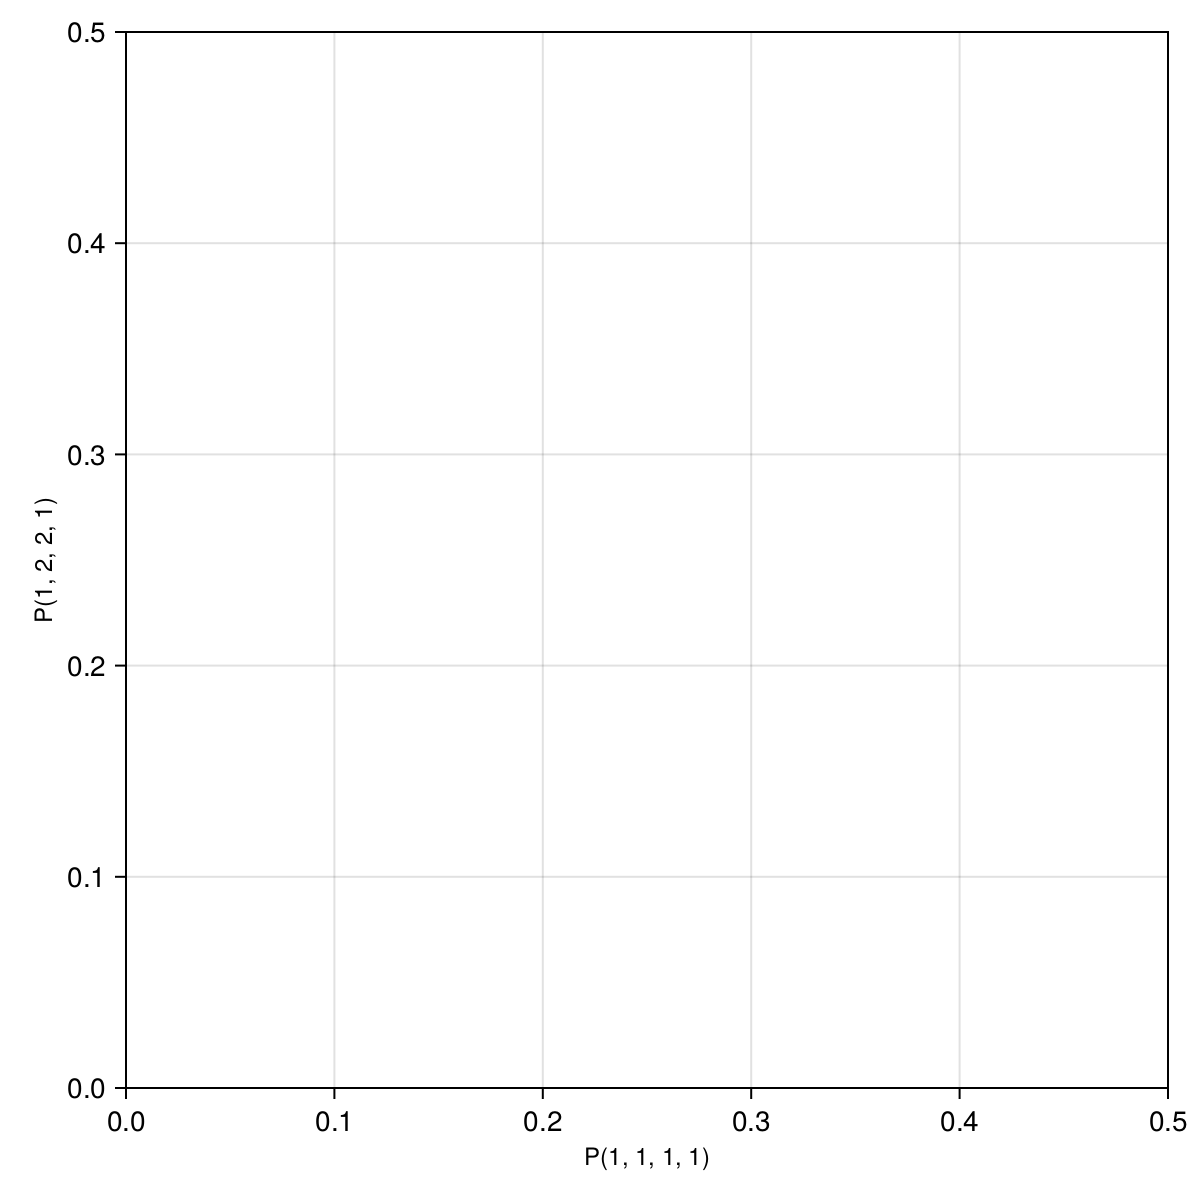

In [22]:
draw_nearest_boxes_in_prob_space(;
    BaseBox=CanonicalPR,
    Dim1=(0,0,0,0), # (a=0, b=0, x=1, y=1)
    Dim2=(0,1,0,0), # (a=0, b=1, x=1, y=0)
    Dim3=(0,1,1,0), # (a=1, b=0, x=0, y=1)
    member_npa_level=3,
    dist_npa_level=2,
    precision=1.4e-2,   # 1.4e-2
    precisionQ=4e-3,    # 1e-4
    markersize=10,        #2
    verbose=true,
    )

##### Distances:

In [15]:


function draw_box_to_NPA_distances(;Box1::Pair{String, Array{Float64,4}}, Box2::Pair{String, Array{Float64,4}}, Box3::Pair{String, Array{Float64,4}}, alt_Game_score::Function, max_power::Int, LS_iterations::Int, K_reset::Int, χ::Float64, precision::Float64=0.001, precisionQ::Float64=1e-4, markersize::Real=4, big::Bool=true, verbose::Bool=false)
    # P, P1, P2, P3 are 2x2x2x2 matrices
    # P1 is the most non-local box
    # P2 is the most local box
    # P3 is the box that is local but scores less in CHSH than P1 (often on boundary of Q set)

    wirings.nb_columns<100 && (@warn "WARNING - Increase the number of columns to at least 100 please (i.e. wirings.nb_columns).")

    P1, P2, P3 = Box1.second, Box2.second, Box3.second

    # Draw the initial background triangle:
    x1, y1 = alt_Game_score(P1), CHSH_score(P1) #Stays CHSH because it's the coordinate system of the plot, also in IC
    x2, y2 = alt_Game_score(P2), CHSH_score(P2)
    x3, y3 = alt_Game_score(P3), CHSH_score(P3)

    # Check if our coordinate system is good, i.e. if projected points aren't aligned (= allow 2D viz.):
    ( (x1 - x3)*(y2-y3)==(x2-x3)*(y1-y3) ) && error("We can't make a 2D plot from a 0D or 1D space of points.")
    
    
    # Initialize figure and colors:
    Pawlowski2009_color = :deepskyblue3
    wired_IC_color = :orangered
    NS_color = :black
    Quantum_color = "#e82051"

    fig = Figure(; size=(800,600))
    title_visible = false
    ax = Axis(fig[1, 1]; xlabel = "CHSH'", ylabel = "CHSH", xlabelsize=(big ? 12 : 10), ylabelsize=(big ? 12 : 10),
            #titlevisible=title_visible, titlesize=(big ? 15 : 12.5), title =L"IC Violating Boxes ($K_{{reset}}$=%$(K_reset), χ=%$(χ), m=$10^%$(Int(log10(m)))$, M=%$(LS_iterations), N=%$(max_power)).",
            )
    xlims!(ax, min(x1, x2, x3), max(x1, x2, x3))
    #ylims!(ax, min(y1, y2, y3), max(y1, y2, y3))
    ylims!(ax, 2, 4)


     # Draw Q-set distances
     dist_resolution = 0.2
     ns_alt_G_scores = min(x2,x3):dist_resolution:max(x2, x3)
     ns_CHSH_scores = 2:dist_resolution:4
     #box_Q_distances = Matrix{Float64}(undef, length(ns_alt_G_scores), length(ns_CHSH_scores))
     box_Q_distances = ones(length(ns_alt_G_scores), length(ns_CHSH_scores))
     for (x_coord, c_alt_G_score_val) in enumerate(ns_alt_G_scores)
         for (y_coord, c_CHSH_score_val) in enumerate(ns_CHSH_scores)
             if c_CHSH_score_val - precisionQ > maximum(ns_CHSH_scores) - c_alt_G_score_val  #Not on the canvas of our viz anymore?
                 break
             end
             dist = distance_to_NPA_Q(c_alt_G_score_val, c_CHSH_score_val, P1, P2, P3, alt_Game_score, 3)
             @show (x_coord, y_coord, dist)
             box_Q_distances[x_coord, y_coord] = dist
         end
     end
     hm = heatmap!(ax, ns_alt_G_scores, ns_CHSH_scores, box_Q_distances; colormap = :Spectral, transparency = 0.5) # colorrange = (0, 1),
     Colorbar(fig[:, end+1], hm)


    text!(ax, Box1.first, position=(x1+0.001, y1), space = :data, align = (:center, :baseline),font = :bold)
    text!(ax, Box2.first, position=(x2, y2-0.007), space = :data, align = (:center, :center),font = :bold)
    text!(ax, Box3.first, position=(x3, y3-0.007), space = :data, align = (:center, :center),font = :bold)

    #Draw the Boundary of the NS set:
    ns_boundary_line = lines!(ax, [x1, x2, x3, x1], [y1, y2, y3, y1]; color=NS_color, linewidth=3)

    # Draw the Quantum area:
    c_alt_G_score_val=min(x2,x3) #Initialize at x-axis origin
    c_CHSH_score_val=4 #Safely initialize at the maximum local value of CHSH
    Quantum_alt_G_scores = Float64[]
    Quantum_CHSH_scores = Float64[]
    while c_alt_G_score_val <= max(x2, x3)
        #Check NPA-Q membership with and without security check
        if is_in_NPA(c_alt_G_score_val, c_CHSH_score_val, P1, P2, P3, alt_Game_score, member_npa_level)
        #if is_in_NPA(c_alt_G_score_val, c_CHSH_score_val, P1, P2, P3, alt_Game_score, member_npa_level) && is_asymp_in_pyNPA(c_alt_G_score_val, c_CHSH_score_val, P1, P2, P3, alt_Game_score, member_npa_level)
            push!(Quantum_alt_G_scores, c_alt_G_score_val)
            push!(Quantum_CHSH_scores, c_CHSH_score_val)
            c_alt_G_score_val+=precisionQ # Go to the next point along x-axis / vertical line 
            
        else #Else we go down along y-axis towards the Q set. 
            if c_CHSH_score_val - precisionQ > y2  #Still on the canvas of our viz.
                c_CHSH_score_val -= precisionQ
            else
                c_CHSH_score_val=y2 #Take the canvas lower-boundary as the quantum boundary (even if it's not in the Q set) 
                c_alt_G_score_val+=precisionQ # Go to the next point along x-axis / vertical line 
            end
        end
    end
    quantum_boundary_line = lines!(ax, Quantum_alt_G_scores, Quantum_CHSH_scores; color=Quantum_color, linewidth=3)

   
    #Misc. plot settings:
    
    legend_visible = true
    legend_visible ? (axislegend(ax, [ns_boundary_line, quantum_boundary_line], 
                    ["NS boundary","Quantum boundary"];
                    position = :rt, labelsize = (big ? 10.5 : 9.5) )) : nothing
    
    
    fig # equiv. to plt.show()
    #return precision
end

draw_box_to_NPA_distances (generic function with 1 method)

In [16]:
draw_box_to_NPA_distances(;
    Box1= "PR"=>CanonicalPR,
    Box2= "I"=>MaxMixedBox,
    Box3= "PL(0,0,0,0)"=> PL(0,0,0,0),
    alt_Game_score=CHSHprime_score,
    max_power= 3,       # 10
    LS_iterations = 2,  # 20
    K_reset = 2,        # 10
    χ = 0.5,          # 0.1
    precision=1.4e-2,   # 1.4e-2
    precisionQ=4e-3,    # 1e-4
    markersize=2,        #2
    verbose=true
    )


┌ Warning: WARNING - Increase the number of columns to at least 100 please (i.e. wirings.nb_columns).
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\test\sdp_tests.ipynb:9


UndefVarError: UndefVarError: `distance_to_NPA_Q` not defined